In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import visdom

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary

import h5py
%matplotlib notebook

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [4]:
device

device(type='cuda')

python -m visdom.server

In [5]:
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = visdom.Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y, xlabel = 'Epochs'):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel=xlabel,
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')
    
    def ImgPlot(self, img, title, caption):
        self.viz.images(
            img,
            opts=dict(title=title, caption=caption
                 
        ))
        
    def VoxelPlot(self, voxels, title):
        dataIO.plotVoxelVisdom(voxels, self.viz, title)

In [6]:
global plotter
plotter = VisdomLinePlotter()

## Dataset loader

In [7]:
path_h5 = '/home/ankbzpx/datasets/ShapeNet/ShapeNetRenderingh5_v1/03001627/'

In [8]:
class ChairDepthDataset(Dataset):
    
    def __init__(self, h5_file):
        
        self.hf = h5py.File(h5_file, 'r')
        self.keys = list(self.hf.keys())
        
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        
        group = self.hf[self.keys[idx]]
        
        depth_img = self.to_tensor(Image.fromarray(np.array(group['depth_img'])))
        target_vox = torch.tensor(group['target_vox'], dtype=torch.float)
        trimap = torch.tensor(group['trimap'], dtype=torch.long)
        
        sample = {'depth_img': depth_img,
                  'target_vox': target_vox,
                  'trimap':trimap,
                 }

        return sample

In [9]:
train_depth_dataset = ChairDepthDataset(path_h5 + 'data_train_rescale.h5')

batch_size = 64

train_model_dataloader = DataLoader(train_depth_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=12)

In [10]:
len(train_model_dataloader)

1976

In [11]:
from vis_utils import plotFromVoxels, plotImg

In [12]:
discrete_encoder_path = 'discrete_encoder.pth'
mapping_path = 'mapping.pth'
discrete_decoder_path = 'discrete_decoder.pth'
unet_path = 'con_unet_full.pth'

from models import Discrete_encoder, Mapping, Discrete_decoder, Conditional_UNET_FULL

####################
# Discrete Encoder #
####################

discrete_encoder = Discrete_encoder().to(device)
discrete_encoder.load_state_dict(torch.load(discrete_encoder_path))
discrete_encoder.eval()

for child in discrete_encoder.children():
    for param in child.parameters():
        param.requires_grad = False
        
####################
# Mapping #
####################

mapping = Mapping().to(device)
mapping.load_state_dict(torch.load(mapping_path))
mapping.eval()

for child in mapping.children():
    for param in child.parameters():
        param.requires_grad = False
        
####################
# Discrete Decoder #
####################

discrete_decoder = Discrete_decoder().to(device)
discrete_decoder.load_state_dict(torch.load(discrete_decoder_path))
discrete_decoder.eval()

for child in discrete_decoder.children():
    for param in child.parameters():
        param.requires_grad = False

In [13]:
########
# UNET #
########

unet = Conditional_UNET_FULL().to(device)
summary(unet, [(1, 32, 32, 32), (256, 1, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 32, 32, 32]             896
       BatchNorm3d-2       [-1, 32, 32, 32, 32]              64
              ReLU-3       [-1, 32, 32, 32, 32]               0
         MaxPool3d-4       [-1, 32, 16, 16, 16]               0
            Conv3d-5       [-1, 32, 16, 16, 16]          27,680
       BatchNorm3d-6       [-1, 32, 16, 16, 16]              64
              ReLU-7       [-1, 32, 16, 16, 16]               0
            Conv3d-8       [-1, 64, 16, 16, 16]          55,360
       BatchNorm3d-9       [-1, 64, 16, 16, 16]             128
             ReLU-10       [-1, 64, 16, 16, 16]               0
        MaxPool3d-11          [-1, 64, 8, 8, 8]               0
           Conv3d-12          [-1, 64, 8, 8, 8]         110,656
      BatchNorm3d-13          [-1, 64, 8, 8, 8]             128
             ReLU-14          [-1, 64, 

In [14]:
num_epochs = 50
start_epoch = 0
lr = 3e-4

ce_loss = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 2.0, 4.0]).to(device))

optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

In [ ]:
# Training Loop
batch_len = len(train_model_dataloader)

print("Starting Training Loop...")

for epoch in range(start_epoch, num_epochs):
    
    loss_list = []
    
    print("Epoch: ", epoch)
    
    count = 0
    
    for i, data in enumerate(train_model_dataloader):
        
        # Input image
        depth_img = data['depth_img'].to(device)
        trimap = data['trimap'].squeeze(1).to(device)
        
        optimizer.zero_grad()
        
        z = discrete_encoder(depth_img)
        
        pred = unet(torch.sigmoid(discrete_decoder(mapping(z))), z)
        
        loss = ce_loss(pred, trimap)
        
        loss.backward()
        
        loss_list.append(loss.item())
        
        optimizer.step()
        
        count += 1
        
        plotter.plot('loss', 'CE', 'Batch Loss', batch_len * epoch + i, loss.item(), 'batch')
        
        if count % 500 == 0:
            torch.save(unet.state_dict(), unet_path)
            
    plotter.plot('Average', 'CE', 'Epoch loss', epoch, np.average(loss_list))
    
    torch.save(unet.state_dict(), unet_path)
    
print("Training finished")

Starting Training Loop...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12


In [16]:
class ChairDepthDataset(Dataset):
    
    def __init__(self, h5_file):
        
        self.hf = h5py.File(h5_file, 'r')
        self.keys = list(self.hf.keys())
        
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        
        group = self.hf[self.keys[idx]]
        
        model_id = str(group['model_id'])
        depth_img_raw = self.to_tensor(Image.fromarray(np.array(group['depth_img'])))
        target_vox = torch.tensor(group['target_vox'], dtype=torch.float)
        trimap = torch.tensor(group['trimap'], dtype=torch.long).squeeze(0)
        
        depth_img = nn.functional.interpolate(depth_img_raw.unsqueeze(0), size=256, mode='nearest').squeeze(0)
        
        sample = {'model_id': model_id,
                  'depth_img': depth_img,
                  'target_vox': target_vox,
                  'trimap': trimap,
                 }

        return sample

test_depth_dataset = ChairDepthDataset(path_h5 + 'data_test_rescale.h5')

In [17]:
unet.eval()

for child in unet.children():
    for param in child.parameters():
        param.requires_grad = False

In [18]:
depth_img = test_depth_dataset[9*24]['depth_img'].to(device).unsqueeze(0)

out_vox = torch.sigmoid(discrete_decoder(mapping(discrete_encoder(depth_img))))

segmentation = torch.softmax(unet(out_vox), dim = 1)

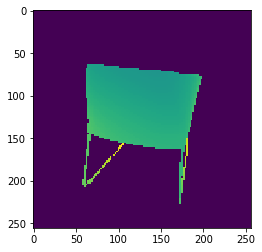

In [19]:
plotImg(depth_img[0, 0].detach().cpu())

In [20]:
segmentation.shape

torch.Size([1, 3, 32, 32, 32])

<IPython.core.display.Javascript object>


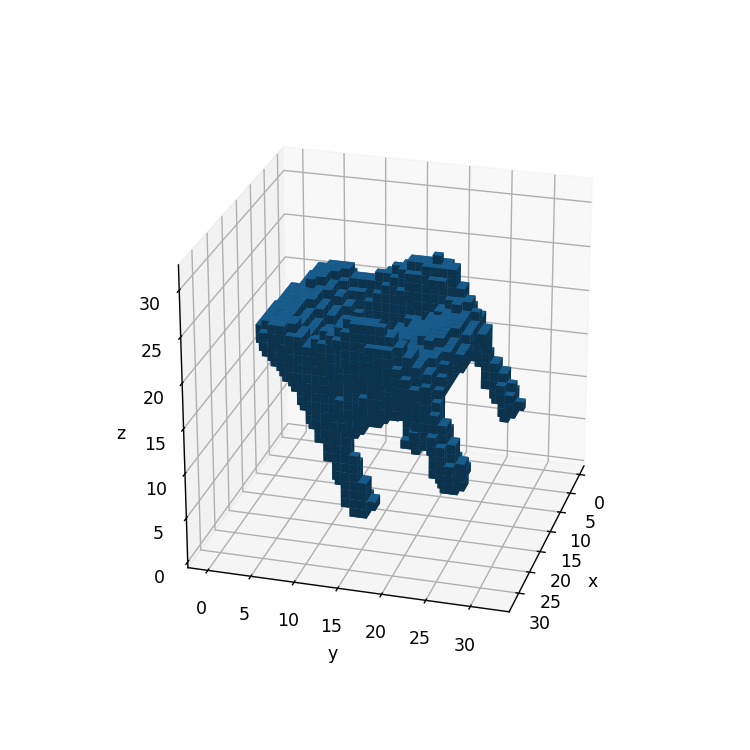

In [21]:
%matplotlib notebook
plotFromVoxels((segmentation[0, 1] > 0.5).detach().cpu().numpy())